# Data selection and processing

In [1]:
import read_data as imp
import numpy as np
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt
import seaborn as sns
from ta import *
import itertools as it
# Para la implementacion de ta en análisis técnico, ver:
# https://buildmedia.readthedocs.org/media/pdf/technical-analysis-library-in-python/latest/technical-analysis-library-in-python.pdf

import warnings
warnings.filterwarnings("ignore")

C:\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### Auxiliar Functions

In [2]:
def normalize(x,time):
    return (x-x.rolling(time, min_periods = 1).min())/(x.rolling(time, min_periods = 1).max()-x.rolling(time, min_periods = 1).min())

def max_rate(x,time):
    return x/x.rolling(time, min_periods = 1).max()

def min_rate(x,time):
    return x/x.rolling(time, min_periods = 1).min()

def past_return(x,n):
    y = pd.DataFrame()
    for i in range(n):
        key = 'T-'+str(i+1)
        y[key] = x['Close']/x['Close'].shift(i+1)-1
    return y

# Parameters of filtering and vec-space construction

In [3]:
dr = 0.05               # Desired return
Time_Window = 3         # Time window to see into the future
P_Ret = 10              # Past return to consider
max_min_tw = 10         # timewindow for support and resistance
n_means=[[20],[200]]    # moving averages for features
windows_ref = 60        # past information needed to normalize
precision = 0.99        # precision to pick the number of eigen vectors to use

dropable_col = ['volatility_kchi', 'volatility_kcli', 'trend_adx', 'trend_adx_pos',
                'volatility_atr', 'volatility_bbhi', 'volatility_dchi', 'trend_adx_neg']

In [4]:
symbols = list(pd.read_csv("Tickers.txt", sep="\n", header=None)[0].values)
# symbols = symbols[:3]
symbols = ['XLP','XLY','XLE','XLF','XLV','XLI','XLK','XLU']
symbols

['XLP', 'XLY', 'XLE', 'XLF', 'XLV', 'XLI', 'XLK', 'XLU']

In [5]:
path_features = "Features.txt"
features = list(pd.read_csv(path_features, sep="\n", header=None)[0].values)
features

['DXY Curncy',
 'EUR Curncy',
 'GT10 Govt',
 'GT2 Govt',
 'GT5 Govt',
 'SPX Index',
 'VIX Index']

In [6]:
years = [x for x in range(2000,2019)]
hist_data = imp.organizarTodo(symbols,years)
hist_feature = imp.organizarTodo(features,years,True)
hist_data

{'XLP':                Open     High      Low    Close    Volume
 Date                                                    
 2000-01-03  23.1250  23.1250  22.4688  22.7500    634300
 2000-01-04  22.3125  22.6563  22.0781  22.1094    172000
 2000-01-05  22.2656  22.6094  22.0938  22.5000    343600
 2000-01-06  22.6563  23.0000  22.4844  22.9219    420800
 2000-01-07  23.3281  24.4219  23.2656  24.3750    337100
 2000-01-10  24.1250  24.2969  23.7344  23.8281    451700
 2000-01-11  23.9375  24.1563  23.7656  23.8281    142900
 2000-01-12  24.0000  24.1875  23.8750  23.9531     84300
 2000-01-13  24.0938  24.2813  23.7656  24.0781    233800
 2000-01-14  24.4688  24.4844  23.8750  24.1563     76100
 2000-01-17  24.4688  24.4844  23.8750  24.1563     76100
 2000-01-18  23.8906  24.0469  23.6563  23.7500    218300
 2000-01-19  23.8594  24.0313  23.7031  23.9219    137800
 2000-01-20  24.0469  24.0469  23.3906  23.5938    425500
 2000-01-21  23.7344  23.7344  23.1250  23.3281    345000
 2000-0

In [7]:
hist_feature

{'DXY Curncy':                Open     High      Low    Close  Volume
 Date                                                  
 2000-01-03  101.670  101.830  100.190  100.220     NaN
 2000-01-04  100.550  100.860  100.010  100.410     NaN
 2000-01-05  100.420  100.470   99.710  100.380     NaN
 2000-01-06  100.310  100.810   99.810  100.480     NaN
 2000-01-07  100.490  100.930  100.440  100.720     NaN
 2000-01-10  100.700  101.180  100.650  100.990     NaN
 2000-01-11  101.030  101.100  100.490  100.560     NaN
 2000-01-12  100.510  100.980  100.240  100.620     NaN
 2000-01-13  100.690  101.140  100.570  101.000     NaN
 2000-01-14  100.950  101.970  100.880  101.720     NaN
 2000-01-17  101.810  101.810  101.740  101.770     NaN
 2000-01-18  101.750  102.110  101.640  101.860     NaN
 2000-01-19  101.670  102.080  101.560  101.760     NaN
 2000-01-20  101.770  102.070  101.220  101.360     NaN
 2000-01-21  101.360  102.050  101.120  101.810     NaN
 2000-01-24  102.230  102.490  101

In [8]:
HF = pd.DataFrame(columns=hist_feature.keys())

for feat,df in hist_feature.items():
    df_aux = df.copy()
    HF[feat] = df_aux['Close']
    for i in it.product(*n_means):
        HF[feat+'_MAS_'+str(i[1])+"_"+str(i[0])] = df_aux['Close'].rolling(window=i[1], min_periods = 1).mean()-df_aux['Close'].rolling(window=i[0], min_periods = 1).mean()
        HF[feat+'_MAR_'+str(i[1])+"_"+str(i[0])] = df_aux['Close'].rolling(window=i[1], min_periods = 1).mean()/df_aux['Close'].rolling(window=i[0], min_periods = 1).mean()
        HF[feat+'_EMAS_'+str(i[1])+"_"+str(i[0])] = df_aux['Close'].ewm(span=i[1], adjust=False, min_periods = 1).mean()-df_aux['Close'].ewm(span=i[0], adjust=False, min_periods = 1).mean()
        HF[feat+'_EMAR_'+str(i[1])+"_"+str(i[0])] = df_aux['Close'].ewm(span=i[1], adjust=False, min_periods = 1).mean()/df_aux['Close'].ewm(span=i[0], adjust=False, min_periods = 1).mean()
HF = HF.apply(normalize, time = windows_ref)
HF

,DXY Curncy,EUR Curncy,GT10 Govt,GT2 Govt,GT5 Govt,SPX Index,VIX Index,DXY Curncy_MAS_200_20,DXY Curncy_MAR_200_20,DXY Curncy_EMAS_200_20,...,GT5 Govt_EMAS_200_20,GT5 Govt_EMAR_200_20,SPX Index_MAS_200_20,SPX Index_MAR_200_20,SPX Index_EMAS_200_20,SPX Index_EMAR_200_20,VIX Index_MAS_200_20,VIX Index_MAR_200_20,VIX Index_EMAS_200_20,VIX Index_EMAR_200_20
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,0.000000,...,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,0.000000,0.000000
2000-01-05,0.842105,1.000000,1.000000,0.694118,0.817308,0.048208,0.785714,NaN,NaN,0.000000,...,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,0.000000,0.000000
2000-01-06,1.000000,1.000000,0.278351,0.000000,0.192308,0.072222,0.542857,NaN,NaN,0.000000,...,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,0.000000,0.000000
2000-01-07,1.000000,0.611765,0.185567,0.105882,0.125000,0.753584,0.000000,NaN,NaN,0.000000,...,1.000000,1.000000,NaN,NaN,0.989306,0.989299,NaN,NaN,0.541148,0.535714
2000-01-10,1.000000,0.152941,0.567010,0.705882,0.605769,1.000000,0.000000,NaN,NaN,0.000000,...,1.000000,1.000000,NaN,NaN,0.866712,0.865777,NaN,NaN,1.000000,1.000000
2000-01-11,0.441558,1.000000,1.000000,1.000000,1.000000,0.672740,0.149057,NaN,NaN,0.000000,...,0.699434,0.698629,NaN,NaN,0.888372,0.887670,NaN,NaN,1.000000,1.000000
2000-01-12,0.519481,0.709677,1.000000,1.000000,1.000000,0.564283,0.213208,NaN,NaN,0.000000,...,0.240178,0.239473,NaN,NaN,0.950777,0.950669,NaN,NaN,1.000000,1.000000
2000-01-13,1.000000,0.161290,0.645631,0.549133,0.628019,0.863871,0.000000,NaN,NaN,0.000000,...,0.114461,0.114069,NaN,NaN,0.884666,0.884089,NaN,NaN,1.000000,1.000000


In [9]:
dates_indexes = {}

for key,value in hist_data.items():
    dates_indexes[key] = value['Close']/value['Close'].shift(-Time_Window)-1 > dr
dates_indexes

{'XLP': Date
 2000-01-03    False
 2000-01-04    False
 2000-01-05    False
 2000-01-06    False
 2000-01-07    False
 2000-01-10    False
 2000-01-11    False
 2000-01-12    False
 2000-01-13    False
 2000-01-14    False
 2000-01-17    False
 2000-01-18    False
 2000-01-19     True
 2000-01-20     True
 2000-01-21    False
 2000-01-24    False
 2000-01-25    False
 2000-01-26    False
 2000-01-27    False
 2000-01-28    False
 2000-01-31    False
 2000-02-01    False
 2000-02-02    False
 2000-02-03    False
 2000-02-04    False
 2000-02-07    False
 2000-02-08     True
 2000-02-09    False
 2000-02-10    False
 2000-02-11    False
               ...  
 2018-11-21    False
 2018-11-22    False
 2018-11-23    False
 2018-11-26    False
 2018-11-27    False
 2018-11-28    False
 2018-11-29    False
 2018-11-30    False
 2018-12-03    False
 2018-12-04    False
 2018-12-05    False
 2018-12-06    False
 2018-12-07    False
 2018-12-10    False
 2018-12-11    False
 2018-12-12    False


In [10]:
for share,df1 in hist_data.items():
    df_aux = df1.copy()
    df_aux = add_all_ta_features(df_aux, "Open", "High", "Low", "Close", "Volume", fillna=True)
    df_aux['Vol_Max'] = max_rate(df_aux['Volume'],max_min_tw)
    df_aux['Clo_Max'] = max_rate(df_aux['Close'],max_min_tw)
    df_aux['Ope_Max'] = max_rate(df_aux['Open'],max_min_tw)
    df_aux['Hig_Max'] = max_rate(df_aux['High'],max_min_tw)
    df_aux['Low_Max'] = max_rate(df_aux['Low'],max_min_tw)
    
    df_aux['Vol_Min'] = min_rate(df_aux['Volume'],max_min_tw)
    df_aux['Clo_Min'] = min_rate(df_aux['Close'],max_min_tw)
    df_aux['Ope_Min'] = min_rate(df_aux['Open'],max_min_tw)
    df_aux['Hig_Min'] = min_rate(df_aux['High'],max_min_tw)
    df_aux['Low_Min'] = min_rate(df_aux['Low'],max_min_tw)
    
    df_aux['Support'] = df_aux['Close']/df_aux['Low'].rolling(window=max_min_tw, min_periods = 1).median()-1
    df_aux['Resistance'] = df_aux['Close']/df_aux['High'].rolling(window=max_min_tw, min_periods = 1).median()-1
    
    df_aux = df_aux.apply(normalize, time = windows_ref)
    df_aux = df_aux.drop(dropable_col, axis = 1)
    
    df_past_r = past_return(df1, n = P_Ret)
    df_aux = pd.concat([df_aux,df_past_r,HF], axis = 1)
    
    hist_data[share] = df_aux

In [11]:
hist_data['XLP']

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,GT5 Govt_EMAS_200_20,GT5 Govt_EMAR_200_20,SPX Index_MAS_200_20,SPX Index_MAR_200_20,SPX Index_EMAS_200_20,SPX Index_EMAR_200_20,VIX Index_MAS_200_20,VIX Index_MAR_200_20,VIX Index_EMAS_200_20,VIX Index_EMAR_200_20
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,...,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,0.000000,0.000000
2000-01-05,0.000000,0.000000,0.040184,0.609741,0.371188,0.671282,1.000000,1.000000,1.000000,0.491897,...,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,0.000000,0.000000
2000-01-06,0.454620,0.757564,1.000000,1.000000,0.538179,1.000000,1.000000,1.000000,1.000000,0.771706,...,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,0.000000,0.000000
2000-01-07,1.000000,1.000000,1.000000,1.000000,0.357127,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,NaN,NaN,0.989306,0.989299,NaN,NaN,0.541148,0.535714
2000-01-10,1.000000,0.931034,1.000000,0.758607,0.605018,0.298172,0.589923,0.691300,0.187504,0.954876,...,1.000000,1.000000,NaN,NaN,0.866712,0.865777,NaN,NaN,1.000000,1.000000
2000-01-11,0.899161,0.853462,1.000000,0.758607,0.000000,0.000000,0.156151,0.615576,0.552379,0.896498,...,0.699434,0.698629,NaN,NaN,0.888372,0.887670,NaN,NaN,1.000000,1.000000
2000-01-12,0.932774,0.870676,1.000000,0.813780,0.000000,0.258670,0.666455,0.584689,0.000000,0.882157,...,0.240178,0.239473,NaN,NaN,0.950777,0.950669,NaN,NaN,1.000000,1.000000
2000-01-13,0.983220,0.922428,0.939117,0.868953,0.271818,0.405189,0.878711,0.607973,0.276731,0.855187,...,0.114461,0.114069,NaN,NaN,0.884666,0.884089,NaN,NaN,1.000000,1.000000


## Taking the dates of interest of the normalized data

In [12]:
Dates_of_Interest = pd.DataFrame(columns = hist_data[[x for x in hist_data.keys()][0]].columns)

for share, df in hist_data.items():
    Dates_of_Interest = Dates_of_Interest.append(df.iloc[dates_indexes[share].values])

Dates_of_Interest = Dates_of_Interest.dropna()
Dates_of_Interest = Dates_of_Interest.transpose()
Dates_of_Interest

,2000-02-22 00:00:00,2000-03-02 00:00:00,2000-03-03 00:00:00,2000-08-04 00:00:00,2001-03-09 00:00:00,2001-03-19 00:00:00,2001-09-18 00:00:00,2002-06-19 00:00:00,2002-06-20 00:00:00,2002-07-08 00:00:00,...,2009-05-12 00:00:00,2010-05-17 00:00:00,2011-08-01 00:00:00,2011-08-03 00:00:00,2013-06-18 00:00:00,2015-08-19 00:00:00,2015-08-20 00:00:00,2015-08-21 00:00:00,2016-11-07 00:00:00,2016-11-08 00:00:00
Open,0.000000,0.000000,0.061812,0.864865,0.120426,0.000000,0.597938,0.205128,0.212454,0.148718,...,1.000000,0.603659,0.507042,0.000000,0.230583,0.964871,0.990632,0.936768,0.281863,0.453431
High,0.032804,0.000000,0.007770,0.777778,0.132174,0.000000,0.556757,0.206478,0.101215,0.072829,...,0.930736,0.470588,0.476821,0.000000,0.224227,1.000000,1.000000,0.889140,0.362205,0.509186
Low,0.016676,0.020655,0.024780,0.794299,0.163265,0.022409,0.528796,0.250859,0.209622,0.146530,...,1.000000,0.792373,0.379747,0.000000,0.205514,0.961722,0.988038,0.887560,0.233766,0.514286
Close,0.111097,0.041204,0.014981,0.831092,0.158277,0.064423,0.505051,0.154440,0.073359,0.067024,...,1.000000,0.497110,0.380000,0.000000,0.261501,1.000000,0.938776,0.814059,0.453865,0.548628
Volume,0.389912,1.000000,0.133696,0.036020,0.012815,0.043578,0.133788,0.019289,0.050152,0.056650,...,0.060190,0.348984,0.409660,0.921262,0.267915,0.125633,0.308582,0.618030,0.442386,0.489542
volume_adi,0.539654,0.757747,0.819585,0.667467,0.446084,0.476019,0.922788,0.545763,0.489298,0.554192,...,0.471475,0.677133,0.204807,0.436021,0.773291,0.656215,0.431968,0.003328,0.502731,0.767800
volume_obv,0.190851,0.776889,0.658330,0.726562,0.692588,0.552952,0.000000,0.161095,0.151629,0.001280,...,1.000000,0.421115,0.686846,0.000000,0.579996,0.993530,0.960411,0.911813,0.790139,0.814118
volume_cmf,0.397177,0.369922,0.360984,0.685313,0.932658,0.764158,0.973624,0.380815,0.329942,0.332129,...,0.832826,0.267175,0.245798,0.284987,0.227224,1.000000,1.000000,0.876283,0.659688,0.745376
volume_fi,0.401562,0.000000,0.438291,0.640010,0.675303,0.668504,0.361316,0.545974,0.522371,0.551816,...,0.472869,0.864311,0.417749,0.000000,0.683247,0.471729,0.469382,0.267537,0.688815,0.716697
volume_em,0.441260,0.567829,0.579209,0.422416,0.259948,0.000000,0.286202,0.561415,0.434009,0.150481,...,0.941617,0.158789,0.521897,0.302139,0.438940,0.891868,0.793246,0.704408,0.777409,0.857648


In [13]:
Dates_of_Interest.shape

(112, 881)

### Every Feature

In [14]:
for i in Dates_of_Interest.index:
    print(i)

Open
High
Low
Close
Volume
volume_adi
volume_obv
volume_cmf
volume_fi
volume_em
volume_vpt
volume_nvi
volatility_bbh
volatility_bbl
volatility_bbm
volatility_bbli
volatility_kcc
volatility_kch
volatility_kcl
volatility_dch
volatility_dcl
volatility_dcli
trend_macd
trend_macd_signal
trend_macd_diff
trend_ema_fast
trend_ema_slow
trend_vortex_ind_pos
trend_vortex_ind_neg
trend_vortex_diff
trend_trix
trend_mass_index
trend_cci
trend_dpo
trend_kst
trend_kst_sig
trend_kst_diff
trend_ichimoku_a
trend_ichimoku_b
trend_visual_ichimoku_a
trend_visual_ichimoku_b
trend_aroon_up
trend_aroon_down
trend_aroon_ind
momentum_rsi
momentum_mfi
momentum_tsi
momentum_uo
momentum_stoch
momentum_stoch_signal
momentum_wr
momentum_ao
others_dr
others_dlr
others_cr
Vol_Max
Clo_Max
Ope_Max
Hig_Max
Low_Max
Vol_Min
Clo_Min
Ope_Min
Hig_Min
Low_Min
Support
Resistance
T-1
T-2
T-3
T-4
T-5
T-6
T-7
T-8
T-9
T-10
DXY Curncy
EUR Curncy
GT10 Govt
GT2 Govt
GT5 Govt
SPX Index
VIX Index
DXY Curncy_MAS_200_20
DXY Curncy_MAR_200_

## Build of the $\Phi$ Matrix

In [15]:
Phi_Mat_regular = np.array(Dates_of_Interest.values, dtype=float)
phi_mean = np.reshape(np.mean(Phi_Mat_regular,axis=1),(-1,1))
phi_mean

array([[ 0.3167209 ],
       [ 0.29081475],
       [ 0.32162878],
       [ 0.31681859],
       [ 0.3255115 ],
       [ 0.51759519],
       [ 0.42320904],
       [ 0.4856079 ],
       [ 0.559258  ],
       [ 0.47028588],
       [ 0.49561838],
       [ 0.44130093],
       [ 0.31219048],
       [ 0.2571573 ],
       [ 0.24329519],
       [ 0.10669694],
       [ 0.24454447],
       [ 0.2445987 ],
       [ 0.25081837],
       [ 0.29847709],
       [ 0.22268082],
       [ 0.20204313],
       [ 0.40579552],
       [ 0.38658289],
       [ 0.47678912],
       [ 0.23696885],
       [ 0.21894993],
       [ 0.43864922],
       [ 0.57406131],
       [ 0.42536164],
       [ 0.38033096],
       [ 0.58676689],
       [ 0.45746772],
       [ 0.55218959],
       [ 0.38402792],
       [ 0.38608664],
       [ 0.42252125],
       [ 0.22487387],
       [ 0.22630507],
       [ 0.31512077],
       [ 0.32809171],
       [ 0.33918171],
       [ 0.64943464],
       [ 0.35043783],
       [ 0.47925309],
       [ 0

In [16]:
Phi_Mat_centered = Phi_Mat_regular - phi_mean
Phi_Mat_centered.shape

(112, 881)

In [17]:
CM = np.dot(Phi_Mat_centered, Phi_Mat_centered.transpose())
eigenvalues, eigenvectors = np.linalg.eigh(CM)
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

eig_pairs.sort(reverse=True)
eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

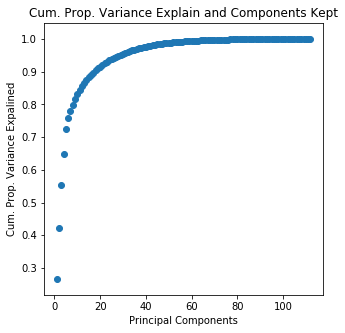

In [18]:
plt.rcParams['figure.figsize'] = [5,5]
var_comp_sum = np.cumsum(eigvalues_sort)/sum(eigvalues_sort)

num_comp = range(1,len(eigvalues_sort)+1)
plt.title('Cum. Prop. Variance Explain and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cum. Prop. Variance Expalined')

plt.scatter(num_comp, var_comp_sum)
plt.show()

## K Eigen values/vectors are kept

In [19]:
K = sum(np.cumsum(eigvalues_sort)/sum(eigvalues_sort)<precision)
K

52

## Weights Calculus

In [20]:
reduced_eig = np.array(eigvectors_sort[:K])
eig_trade = np.dot(reduced_eig,Phi_Mat_centered)
print(eig_trade.shape)
eig_trade

(52, 881)


array([[-5.28766465e-01, -5.41924181e-01, -4.38326068e-01, ...,
         1.98516680e+00,  1.47446684e+00,  1.99617969e+00],
       [ 1.53440862e+00,  1.24145294e+00,  1.02173888e+00, ...,
        -1.64842580e+00,  6.32627273e-01,  1.52532998e-01],
       [-6.53806723e-01, -7.18615458e-01, -7.97047516e-01, ...,
         1.77020031e+00, -1.43251338e+00, -1.61112623e+00],
       ...,
       [ 9.62465782e-02, -6.78705228e-02, -2.24202342e-01, ...,
         5.32090269e-02, -4.70329222e-02, -4.00433817e-02],
       [ 1.18170715e-01,  1.08900743e-01,  1.17002603e-01, ...,
        -6.34459734e-02,  1.72466496e-01,  9.22859553e-02],
       [-3.64138304e-03,  2.75219325e-01,  2.08802953e-01, ...,
        -4.74374318e-02, -1.90266277e-03, -6.60765042e-02]])

In [21]:
all_together = pd.DataFrame(columns = hist_data[[x for x in hist_data.keys()][0]].index)

for ticker, df in hist_data.items():
    all_together = pd.concat([all_together, df.transpose()], axis=1, sort=False)
    all_together = all_together.dropna(axis = 1)
    all_together = all_together.dropna()
all_together

Date,2000-02-11 00:00:00,2000-02-14 00:00:00,2000-02-15 00:00:00,2000-02-16 00:00:00,2000-02-17 00:00:00,2000-02-18 00:00:00,2000-02-21 00:00:00,2000-02-22 00:00:00,2000-02-23 00:00:00,2000-02-24 00:00:00,...,2018-12-14 00:00:00,2018-12-17 00:00:00,2018-12-18 00:00:00,2018-12-24 00:00:00,2018-12-25 00:00:00,2018-12-26 00:00:00,2018-12-27 00:00:00,2018-12-28 00:00:00,2018-12-31 00:00:00,2019-01-01 00:00:00
Open,0.000000,0.000000,0.077364,0.171275,0.082880,0.000000,0.000000,0.000000,0.052067,0.000000,...,1.000000,0.990893,0.693989,0.284464,0.284464,0.000000,0.131238,0.231054,0.236599,0.236599
High,0.000000,0.000000,0.124990,0.107124,0.077371,0.000000,0.000000,0.032804,0.005456,0.000000,...,0.987090,0.958292,0.705065,0.277974,0.277974,0.000000,0.090815,0.212590,0.152735,0.152735
Low,0.000000,0.000000,0.059634,0.072858,0.006654,0.000000,0.000000,0.016676,0.016676,0.000000,...,1.000000,0.666019,0.605825,0.000000,0.000000,0.000000,0.103873,0.319542,0.274648,0.274648
Close,0.000000,0.039115,0.212306,0.100576,0.000000,0.000000,0.000000,0.111097,0.000000,0.000000,...,0.980251,0.651706,0.585278,0.000000,0.000000,0.130354,0.212291,0.236499,0.253259,0.253259
Volume,0.224324,0.294674,0.037996,0.471047,0.136220,0.264974,0.264974,0.389912,0.118799,0.223162,...,0.489913,0.635276,0.446206,0.418308,0.418308,0.653343,0.621469,0.372940,0.235336,0.235336
volume_adi,0.111338,0.260219,0.449034,0.373039,0.208281,0.241862,0.312981,0.539654,0.497217,0.269717,...,0.667679,0.359248,0.160573,0.090122,0.193934,0.684814,1.000000,0.666093,0.510632,0.677392
volume_obv,0.182118,0.346623,0.389479,0.141386,0.051978,0.000000,0.334598,0.190851,0.116973,0.000000,...,0.969559,0.933326,0.904979,0.754745,0.000000,0.791732,0.827389,0.852681,0.872232,0.000000
volume_cmf,0.169261,0.184814,0.251206,0.206347,0.202299,0.226545,0.253000,0.397177,0.366249,0.312343,...,0.703792,0.442025,0.391385,0.003924,0.000000,0.158986,0.232118,0.112773,0.071377,0.178887
volume_fi,0.088728,0.281129,0.151956,0.381048,0.229510,0.525387,0.279460,0.401562,0.361470,0.577359,...,0.704863,0.171625,0.719908,1.000000,0.764082,0.470753,0.499891,0.329861,0.362388,0.393908
volume_em,0.485109,0.526135,0.598927,0.564089,0.511806,0.475233,0.457067,0.441260,0.462250,0.377278,...,0.970082,0.586549,0.358041,0.000000,0.000000,0.000000,0.000000,0.086932,0.034342,0.026818


In [22]:
Recon = []
minESpace = []
allDistESpace = []

for i in range(all_together.shape[1]):
    ob_cent = all_together.iloc[:,i].values - phi_mean[:,0]
    weights = np.dot(reduced_eig,ob_cent).reshape((1,K))
    ghost_trade = np.dot(weights, reduced_eig).transpose() + phi_mean
    Recon.append(np.linalg.norm(all_together.iloc[:,i].values - ghost_trade))
    dist_list = [np.linalg.norm(eig_trade[:,j] - weights.transpose()) for j in range(eig_trade.shape[1])]
    minESpace.append(min(dist_list))
    allDistESpace.append(dist_list)
    

## $\epsilon$  for distances to the TradeSpace

In [23]:
eps_trdspace=np.percentile(minESpace,5)
print(eps_trdspace)

24.379236091501802


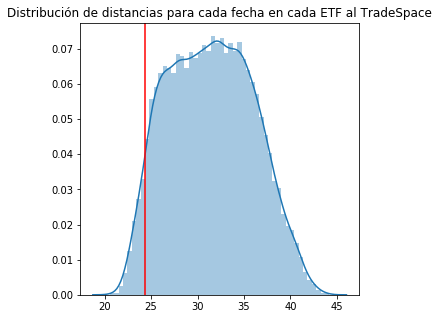

In [24]:
plt.rcParams['figure.figsize'] = [5,5]
sns.distplot(minESpace)
plt.axvline(x=eps_trdspace, color='r')
plt.title('Distribución de distancias para cada fecha en cada ETF al TradeSpace')
plt.show()

## $\epsilon$  for distances to the reconstruction of a trade

In [25]:
eps_recon=np.percentile(Recon,5)
print(eps_recon)

48.960341149199174


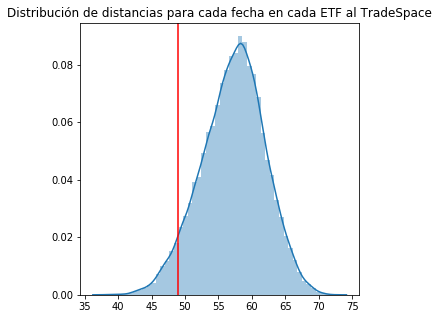

In [26]:
plt.rcParams['figure.figsize'] = [5,5]
sns.distplot(Recon)
plt.axvline(x=eps_recon, color='r')
plt.title('Distribución de distancias para cada fecha en cada ETF al TradeSpace')
plt.show()